In [1]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
import seaborn as sns

# Support Vector Machines

In [130]:
from sklearn.preprocessing import OneHotEncoder

heart = pd.read_csv("Heart.csv").iloc[:,1:]
heart.dropna(axis="rows", inplace=True)
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [131]:
heart = pd.get_dummies(heart,drop_first=True)
heart.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_normal,Thal_reversable,AHD_Yes
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0,1,0,0,0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,0,0,0,1,0,1
2,67,1,120,229,0,2,129,1,2.6,2,2.0,0,0,0,0,1,1
3,37,1,130,250,0,0,187,0,3.5,3,0.0,1,0,0,1,0,0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,0,1,0,1,0,0


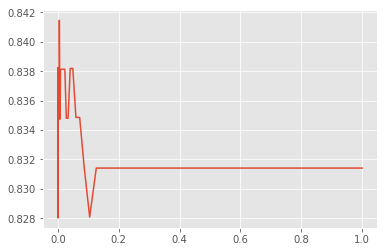

In [183]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X = heart.drop("AHD_Yes", axis="columns")
Y = np.array(heart["AHD_Yes"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


kfold = StratifiedKFold(n_splits=5, random_state = 42, shuffle=True)

C= np.logspace(-4,0,50)
#C = [0.01,0.1,1]
cv_score = []

for penalty in C:
    prediction = []
    
    for train_index, test_index in kfold.split(X_scaled,Y):
        X_train, X_test, y_train, y_test = X_scaled[train_index], X_scaled[test_index], Y[train_index], Y[test_index]
        clf = LinearSVC(C=penalty, max_iter=10000)
        clf.fit(X_train,y_train)
        yhat = clf.predict(X_test)
        prediction.append(accuracy_score(y_test,yhat))
        
    cv_score.append(np.mean(prediction))

    
sns.lineplot(C,cv_score)
    

In [272]:
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

X = heart.drop("AHD_Yes", axis="columns")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Y = heart["AHD_Yes"]

X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y,test_size=.33, random_state=42)
clfs = [LinearSVC(C=.01), SVC(kernel="rbf", C=1, gamma=0.001), LinearDiscriminantAnalysis()]

auc_scores = []
for clf in clfs:
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    auc_scores.append(score)
    
print(auc_scores)

[0.8484848484848485, 0.8383838383838383, 0.8282828282828283]


#### Multiclass classification using SVM

In [410]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import time



X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=5)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

tic = time.time()

clf = SVC(decision_function_shape='ovo')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score_ovo = accuracy_score(y_pred,y_test)

toc = time.time()
elapsed_ovo = toc-tic

tic = time.time()

clf = SVC(decision_function_shape='ovr')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score_ovr = accuracy_score(y_pred,y_test)

toc = time.time()
elapsed_ovr = toc-tic

print("OVO : {0:.4}, OVR : {0:.4}".format(score_ovo,score_ovr))
print("OVO : {0:.4}, OVR : {0:.4}".format(elapsed_ovo,elapsed_ovr))

OVO : 0.715, OVR : 0.715
OVO : 0.03247, OVR : 0.03247


#### GridSearchCV
Albeit not mentioned in the book, gridsearch searches in a given parameter space for the optimal combinations of method parameters.

In [411]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

ads = pd.read_csv("Advertising.csv").iloc[:,1:]
ads.dropna(axis = "rows", inplace=True)

Y = ads["sales"]
X = ads.drop(["sales"], axis = "columns")
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head(2)

,TV,radio,newspaper
0,0.969852,0.981522,1.778945
1,-1.197376,1.082808,0.669579


In [420]:
parameters = {'kernel':("linear","rbf","poly"),
              'C':[0.01,0.1],
              'gamma':("scale","auto"),
              'degree':[1,2,3]}

svr = SVR()
clf = GridSearchCV(svr, parameters, cv=5, scoring='r2')
clf.fit(X_scaled,Y)

print(clf.best_score_)
print(clf.best_params_)
print(clf.best_estimator_)

0.8650245611284436
{'C': 0.1, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
SVR(C=0.1, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


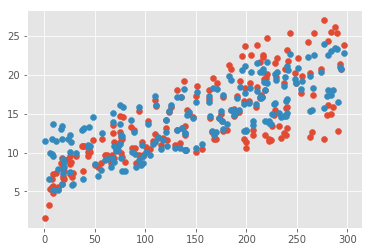

In [418]:
plt.scatter(X["TV"],Y)
plt.scatter(X["TV"],clf.predict(X_scaled))